Binary 3/6 B)

mRNA localization using binary classification (cytoplasm/nucleus) (part 1/2): basic model with:
<br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 4: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance, i.e. PredictionValuesChange), threshold > 0 <br>
c) Method 5: with feature importance-based feature selection (feature importance type: SHAP values), threshold > 0

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report

In [3]:
#data initialization

#Cytoplasm (label = 0)
CP_train = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_train_CSV.csv")
CP_test = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_test_CSV.csv")

#Nucleus (label = 3)
NU_train = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_train_CSV.csv")
NU_test = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_test_CSV.csv")

print("CP TRAIN, TEST SHAPE:", CP_train.shape, ",", CP_test.shape)
print("NU TRAIN, TEST SHAPE:", NU_train.shape, ",", NU_test.shape)

CP TRAIN, TEST SHAPE: (824, 1026) , (206, 1026)
NU TRAIN, TEST SHAPE: (640, 1026) , (160, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:


#Group 3: CP + NU

frames_CN_tra =[CP_train, NU_train]
frames_CN_tes = [CP_test, NU_test]

CP_NU_train = pd.concat(frames_CN_tra)
CP_NU_test = pd.concat(frames_CN_tes)



In [6]:
print("CP + NU TRAIN, TEST SHAPE:", CP_NU_train.shape, ",", CP_NU_test.shape)


CP + NU TRAIN, TEST SHAPE: (1464, 1026) , (366, 1026)


In [7]:
CP_NU_test.head(209)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_16986#79230|0|testing,0,0.008836,0.002834,0.002334,0.003168,0.001667,0.003168,0.000000,0.002001,...,0.000834,0.001834,0.001167,0.000500,0.001667,0.001834,0.001667,0.002501,0.002001,0.011504
1,mRNALoc_8139#3082|0|testing,0,0.009503,0.002501,0.003168,0.006002,0.003001,0.000834,0.000167,0.002668,...,0.000167,0.003168,0.001667,0.001334,0.001667,0.003501,0.005835,0.001667,0.003501,0.005669
2,mRNALoc_19034#8816|0|testing,0,0.006005,0.001168,0.002168,0.001168,0.001668,0.001334,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001501,0.000667,0.001668,0.002502,0.001001,0.001334,0.002002
3,mRNALoc_19863#9737|0|testing,0,0.005673,0.001335,0.002503,0.002837,0.001502,0.001335,0.000167,0.001001,...,0.000000,0.001168,0.002002,0.001001,0.002670,0.001001,0.001168,0.000834,0.001669,0.001502
4,mRNALoc_19031#8816|0|testing,0,0.006008,0.001168,0.002170,0.001168,0.001669,0.001335,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001502,0.000668,0.001669,0.002503,0.001001,0.001335,0.002003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,mRNALoc_8179#30957|0|testing,0,0.000732,0.000183,0.000366,0.000732,0.000549,0.000366,0.000183,0.000732,...,0.000000,0.000183,0.000366,0.000732,0.000732,0.000549,0.000183,0.000183,0.000549,0.000000
205,mRNALoc_19660#94229|0|testing,0,0.006595,0.001465,0.002748,0.002565,0.002015,0.000550,0.000183,0.001099,...,0.000183,0.002381,0.003114,0.001649,0.001465,0.001832,0.002931,0.002565,0.003297,0.004396
0,mRNALoc_4836#21374|3|testing,3,0.001632,0.002176,0.001632,0.002176,0.001632,0.001088,0.000544,0.001088,...,0.000000,0.004353,0.000544,0.000544,0.001632,0.002176,0.003264,0.002720,0.002720,0.004897
1,mRNALoc_7063#26002|3|testing,3,0.002176,0.001088,0.003264,0.000544,0.001088,0.000544,0.000000,0.001088,...,0.000544,0.001632,0.001088,0.002176,0.001088,0.000000,0.001088,0.001088,0.001088,0.000544


In [8]:
#FOR CP+NU
noname_CN_train = CP_NU_train.drop("#", axis="columns")
noname_CN_test = CP_NU_test.drop("#", axis="columns")


CP_NU_X_train = noname_CN_train.drop("label", axis="columns")
CP_NU_y_train = noname_CN_train["label"]

CP_NU_X_test = noname_CN_test.drop("label", axis="columns")
CP_NU_y_test = noname_CN_test["label"]

print("CP + NU X train:", CP_NU_X_train.shape)
print("CP + NU y train:", CP_NU_y_train.shape)
print("CP + NU X test:", CP_NU_X_test.shape)
print("CP + NU y test:", CP_NU_y_test.shape)

CP + NU X train: (1464, 1024)
CP + NU y train: (1464,)
CP + NU X test: (366, 1024)
CP + NU y test: (366,)


In [9]:
# Create data pools for feature importance/selection for CP + NU

CN_feature_names = list(CP_NU_X_train.columns)
print("Number of features:", len(CN_feature_names))

CN_train_pool = Pool(CP_NU_X_train, CP_NU_y_train, feature_names=CN_feature_names)

CN_test_pool = Pool(CP_NU_X_test, CP_NU_y_test)

print("*Cytoplasm, Nucleus Pools created")

Number of features: 1024
*Cytoplasm, Nucleus Pools created


Initial classification (without feature importance/selection/hyperparameter tuning)

In [10]:
CN_binary_model = CatBoostClassifier(loss_function="MultiClass")

In [11]:
#Fit model to CN data

CN_binary_model.fit(CN_train_pool)

Learning rate set to 0.08068
0:	learn: 0.6787616	total: 360ms	remaining: 5m 59s
1:	learn: 0.6661041	total: 501ms	remaining: 4m 9s
2:	learn: 0.6540886	total: 621ms	remaining: 3m 26s
3:	learn: 0.6410552	total: 742ms	remaining: 3m 4s
4:	learn: 0.6291499	total: 863ms	remaining: 2m 51s
5:	learn: 0.6191632	total: 986ms	remaining: 2m 43s
6:	learn: 0.6110552	total: 1.1s	remaining: 2m 36s
7:	learn: 0.6018135	total: 1.22s	remaining: 2m 31s
8:	learn: 0.5929751	total: 1.34s	remaining: 2m 27s
9:	learn: 0.5847477	total: 1.47s	remaining: 2m 25s
10:	learn: 0.5764195	total: 1.68s	remaining: 2m 31s
11:	learn: 0.5695532	total: 1.83s	remaining: 2m 30s
12:	learn: 0.5622417	total: 1.94s	remaining: 2m 27s
13:	learn: 0.5563146	total: 2.07s	remaining: 2m 25s
14:	learn: 0.5484330	total: 2.18s	remaining: 2m 23s
15:	learn: 0.5420195	total: 2.31s	remaining: 2m 21s
16:	learn: 0.5352478	total: 2.43s	remaining: 2m 20s
17:	learn: 0.5291749	total: 2.54s	remaining: 2m 18s
18:	learn: 0.5222654	total: 2.66s	remaining: 2m 

In [12]:
#Check parameters used in this model fit

CN_bin_params = CN_binary_model.get_all_params()
print("Basic model parameters:", CN_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.0806799978017807, 

In [13]:
#Prediction using X_test
CN_y_pred = CN_binary_model.predict(CP_NU_X_test)

#Predication probability

CN_y_prob = CN_binary_model.predict_proba(CP_NU_X_test)

In [14]:
# Calculate F1 score and get classification report

print("Model 1: Basic model - Cytoplasm & nucleus")

CN_cr = classification_report(CP_NU_y_test, CN_y_pred, digits=4)
print(CN_cr)

print('Accuracy score: ', accuracy_score(CP_NU_y_test, CN_y_pred))

CN_f1 = f1_score(CP_NU_y_test, CN_y_pred, average='macro')
print(f"F1 Score: {CN_f1}")
# print('Roc auc score : ', roc_auc_score(CP_NU_y_test, CN_y_prob))

Model 1: Basic model - Cytoplasm & nucleus
              precision    recall  f1-score   support

           0     0.6211    0.7718    0.6883       206
           3     0.5727    0.3937    0.4667       160

    accuracy                         0.6066       366
   macro avg     0.5969    0.5828    0.5775       366
weighted avg     0.5999    0.6066    0.5914       366

Accuracy score:  0.6065573770491803
F1 Score: 0.5774891774891775


In [15]:
# Confusion matrix for selected data

print("real values shape:", CP_NU_y_test.shape)
print("prediction shape:", CN_y_pred.shape)

CN_y_pred_fl = CN_y_pred
print("flattened prediction values shape:", CN_y_pred_fl.ravel().shape, "\n")

CN_cMatrix = confusion_matrix(CP_NU_y_test, CN_y_pred_fl)
print(CN_cMatrix)

real values shape: (366,)
prediction shape: (366, 1)
flattened prediction values shape: (366,) 

[[159  47]
 [ 97  63]]


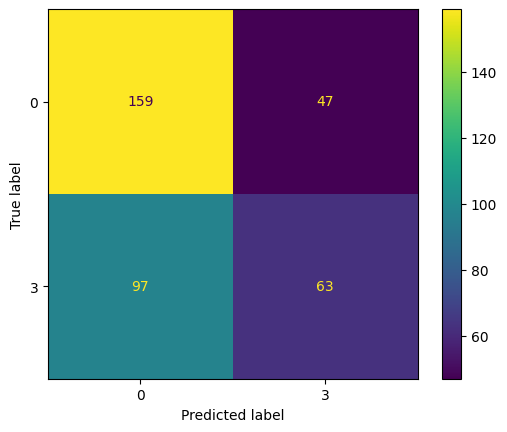

In [16]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CN_cMatrix, display_labels=CN_binary_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [17]:
#Feature importances for CN pair

CN_feat_importances = CN_binary_model.get_feature_importance(prettified=True)
CN_feat_importances.head(100)

,Feature Id,Importances
0,GGGGC,1.294727
1,GAAGA,1.046140
2,AAAAA,0.968291
3,AAGGG,0.942511
4,ATTCG,0.817238
...,...,...
95,GTGGA,0.234200
96,AGTTC,0.232347
97,GTCCC,0.231150
98,GCCGT,0.230021


In [18]:
# Show only feature importances above 0

threshold_chosen_features = CN_feat_importances[CN_feat_importances['Importances'] > 0]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importance above 0 (selected features):", num_chosen_features)

    Feature Id  Importances
0        GGGGC     1.294727
1        GAAGA     1.046140
2        AAAAA     0.968291
3        AAGGG     0.942511
4        ATTCG     0.817238
..         ...          ...
989      TAGTT     0.000760
990      TTAAT     0.000704
991      CCATT     0.000411
992      GCATT     0.000116
993      CACGG     0.000080

[994 rows x 2 columns]

Amount of features with importance above 0 (selected features): 994


In [19]:
print("Sum of total feature importances: ", sum(CN_feat_importances.Importances))
print("Sum of feature importances > 0: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  99.9999999999998
Sum of feature importances > 0:  99.9999999999998


In [20]:
# Select features with importance values above 0.1

CN_selected_feat = CN_feat_importances[:num_chosen_features]['Feature Id'].tolist()

# print(CN_selected_feat)

['GGGGC', 'GAAGA', 'AAAAA', 'AAGGG', 'ATTCG', 'ACGTC', 'GGTCG', 'CTAGC', 'TACTG', 'GGGGA', 'ATTTC', 'TGACG', 'TGCCC', 'GCAGT', 'AATCC', 'CATCT', 'ATCAC', 'CGTTG', 'AATAT', 'CGGTA', 'GCTCT', 'AGGAA', 'TGAAT', 'GCACA', 'GGTGA', 'GTAGC', 'CCCAA', 'CACTC', 'ACGCA', 'CCTCT', 'GTACG', 'CCTGC', 'TAGAC', 'GCCCC', 'CCCCA', 'CAGAC', 'GTATG', 'CCAAT', 'TTCAA', 'GGCAA', 'GAAGT', 'ACCGA', 'TCTCC', 'TCAAT', 'ATGCC', 'GTTAC', 'CTCTA', 'CAGAT', 'GACGA', 'TTGTC', 'GTTTG', 'TATAC', 'GGGAT', 'AGTTG', 'AACGA', 'CTGTA', 'GGATC', 'TAAGG', 'CCTCC', 'AAGTT', 'GGCGA', 'GATAG', 'AGAGT', 'TCCCA', 'TAGCC', 'TGAAG', 'CAATC', 'TTCGA', 'CGAGT', 'GAGTT', 'CCGGC', 'CAAGT', 'ATCTC', 'TGAAC', 'AGGGG', 'CCTAT', 'TCGTA', 'AAGGA', 'TTGCT', 'AACCC', 'TAGGG', 'CTAGT', 'GACAG', 'TTCAC', 'CCCTC', 'CTTGT', 'GGGAG', 'AGCAG', 'TGCTC', 'CAGAG', 'GGGTC', 'AGAAG', 'CTCAG', 'GTTCT', 'CTCGC', 'GTGGA', 'AGTTC', 'GTCCC', 'GCCGT', 'GAGCT', 'TCCTC', 'CTTAC', 'TGTAC', 'CGTGA', 'GCTAG', 'CAGTA', 'CAATT', 'CTTGA', 'TGCGC', 'CGACA', 'GTAGA', 

In [21]:
CP_NU_X_train.shape

(1464, 1024)

In [22]:
# See original training set

CP_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835


In [23]:
#Create training set with selected features 

CN_X_train_selected = CP_NU_X_train[CN_selected_feat]
CN_X_train_selected.head()

,GGGGC,GAAGA,AAAAA,AAGGG,ATTCG,ACGTC,GGTCG,CTAGC,TACTG,GGGGA,...,ATCAG,ATGAG,TGGCG,CTACA,ATATC,TAGTT,TTAAT,CCATT,GCATT,CACGG
0,0.000475,0.001584,0.003643,0.001267,0.000158,0.000317,0.000158,0.000634,0.000317,0.001426,...,0.001109,0.001109,0.000475,0.000475,0.000950,0.000475,0.001109,0.000950,0.001109,0.000475
1,0.004371,0.002040,0.002914,0.001748,0.000291,0.000000,0.000291,0.000583,0.000583,0.002331,...,0.000874,0.000583,0.000291,0.001166,0.000000,0.000583,0.000291,0.002040,0.000583,0.000583
2,0.003208,0.002291,0.002291,0.002750,0.000458,0.000000,0.000000,0.000000,0.000458,0.001833,...,0.000458,0.000458,0.001375,0.000000,0.000000,0.000458,0.002291,0.001833,0.000000,0.002750
3,0.005938,0.000000,0.000000,0.003464,0.000000,0.000000,0.000990,0.000495,0.000990,0.000495,...,0.000495,0.001979,0.002969,0.000495,0.000000,0.000000,0.000000,0.000495,0.000000,0.000000
4,0.000207,0.002281,0.013061,0.001037,0.000207,0.000207,0.000104,0.000311,0.000311,0.000726,...,0.001348,0.001037,0.000207,0.001659,0.000933,0.001140,0.001451,0.001037,0.001451,0.000104


In [24]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CN_X_train_selected.columns) == CN_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [25]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CN_X_train_selected.shape)
print("Shape of y_train (number of labels):", CP_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1464, 994)
Shape of y_train (number of labels): (1464,)


In [26]:
# Create pool object for selected feature data
print("Original number of features:", len(CN_feature_names), "\n Number of selected features:", len(CN_selected_feat))

CN_selected_train_pool = Pool(CN_X_train_selected, CP_NU_y_train, feature_names=CN_selected_feat)

Original number of features: 1024 
 Number of selected features: 994


In [27]:
#Create new model for data with selected features
CN_FIFS_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CN_FIFS_model.fit(CN_selected_train_pool)

Learning rate set to 0.08068
0:	learn: 0.6770613	total: 141ms	remaining: 2m 20s
1:	learn: 0.6635511	total: 254ms	remaining: 2m 6s
2:	learn: 0.6519944	total: 370ms	remaining: 2m 2s
3:	learn: 0.6406108	total: 492ms	remaining: 2m 2s
4:	learn: 0.6292671	total: 606ms	remaining: 2m
5:	learn: 0.6198757	total: 717ms	remaining: 1m 58s
6:	learn: 0.6099177	total: 833ms	remaining: 1m 58s
7:	learn: 0.6002178	total: 950ms	remaining: 1m 57s
8:	learn: 0.5906016	total: 1.07s	remaining: 1m 57s
9:	learn: 0.5824069	total: 1.19s	remaining: 1m 57s
10:	learn: 0.5727625	total: 1.31s	remaining: 1m 57s
11:	learn: 0.5648818	total: 1.43s	remaining: 1m 57s
12:	learn: 0.5592806	total: 1.54s	remaining: 1m 57s
13:	learn: 0.5518700	total: 1.66s	remaining: 1m 57s
14:	learn: 0.5444362	total: 1.78s	remaining: 1m 57s
15:	learn: 0.5374233	total: 1.91s	remaining: 1m 57s
16:	learn: 0.5314803	total: 2.03s	remaining: 1m 57s
17:	learn: 0.5246268	total: 2.15s	remaining: 1m 57s
18:	learn: 0.5193500	total: 2.26s	remaining: 1m 56s


In [28]:
#Check parameters used in this model fit

CN_FIFS_params = CN_FIFS_model.get_all_params()
print("Basic model parameters:", CN_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.0806799978017807, 

In [29]:
# #Check parameters used in this model fit

# CN_FIFS_params = CN_FIFS_model.get_all_params()
# print("Basic model parameters:", CN_FIFS_params)

In [30]:
#Prediction using X_test only for selected features data
CN_FIFS_y_pred = CN_FIFS_model.predict(CP_NU_X_test)

#Predication probability for selected features data

CN_FIFS_y_prob = CN_FIFS_model.predict_proba(CP_NU_X_test)

In [31]:
# Calculate F1 score and get classification report

print("Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - Cytoplasm & nucleus")

print("\nNumber of chosen features:", num_chosen_features, "\n")

CN_FIFS_cr = classification_report(CP_NU_y_test, CN_FIFS_y_pred, digits=4)
print(CN_FIFS_cr)

print('Accuracy score: ', accuracy_score(CP_NU_y_test, CN_FIFS_y_pred))

CN_FIFS_f1 = f1_score(CP_NU_y_test, CN_FIFS_y_pred, average='macro')
print(f"\nF1 Score: {CN_FIFS_f1}")
# print('Roc auc score : ', roc_auc_score(CP_NU_y_test, CN_FIFS_y_prob))

Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - Cytoplasm & nucleus

Number of chosen features: 994 

              precision    recall  f1-score   support

           0     0.5955    0.7718    0.6723       206
           3     0.5253    0.3250    0.4015       160

    accuracy                         0.5765       366
   macro avg     0.5604    0.5484    0.5369       366
weighted avg     0.5648    0.5765    0.5539       366

Accuracy score:  0.5765027322404371

F1 Score: 0.5369244206453508


In [32]:
# Confusion matrix for selected data

print("real values shape:", CP_NU_y_test.shape)
print("prediction shape:", CN_FIFS_y_pred.shape)

CN_FIFS_y_pred_fl = CN_FIFS_y_pred
print("flattened prediction values shape:", CN_FIFS_y_pred_fl.ravel().shape, "\n")

CN_FIFS_cMatrix = confusion_matrix(CP_NU_y_test, CN_FIFS_y_pred_fl)
print(CN_FIFS_cMatrix)

real values shape: (366,)
prediction shape: (366, 1)
flattened prediction values shape: (366,) 

[[159  47]
 [108  52]]


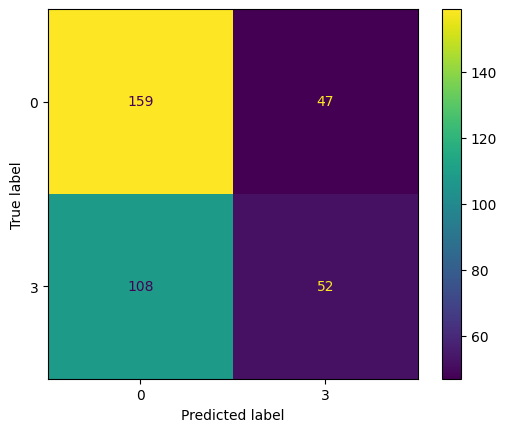

In [33]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CN_FIFS_cMatrix, display_labels=CN_FIFS_model.classes_)
disp.plot()
plt.show()

    Method 3: Modelling using feature selection based on feature importance values (with get_feature_importances type = "ShapValues")

In [34]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(CN_binary_model)

In [35]:
#SHAP values for X_train
CN_shap_values = explainer.shap_values(CP_NU_X_train)

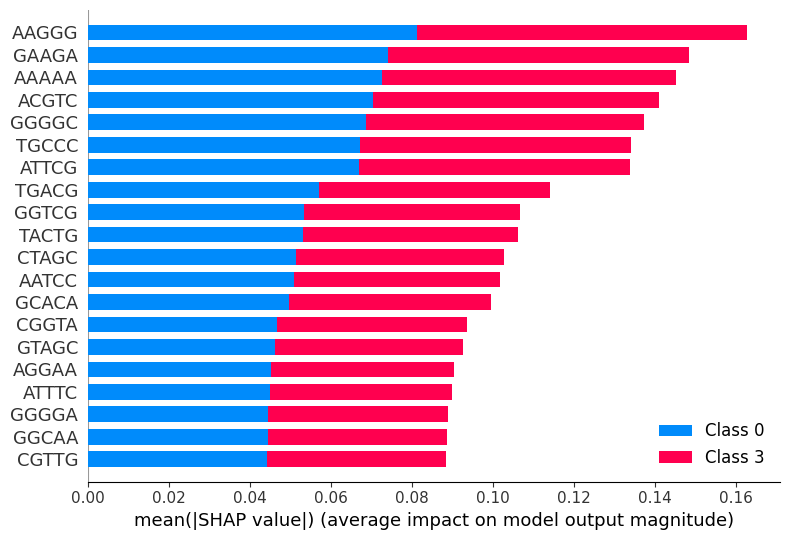

In [36]:
shap.summary_plot(CN_shap_values, CP_NU_X_train, plot_size=0.2, class_names=["Class 0", "Class 3"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


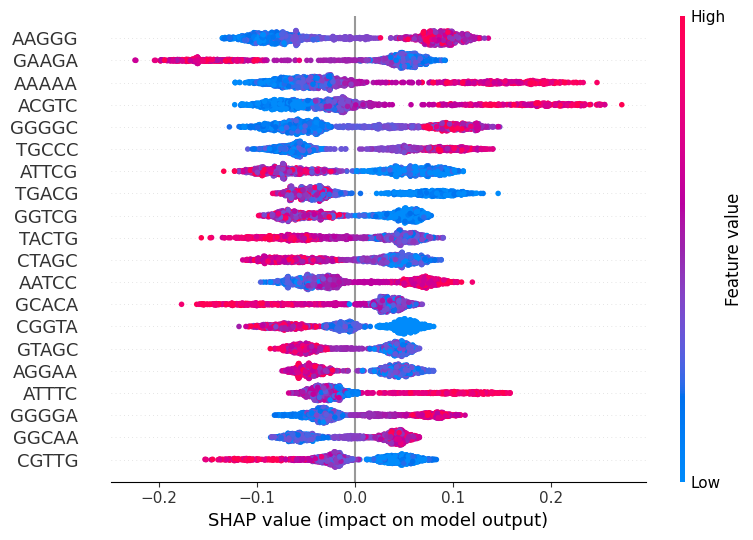

In [37]:
shap.summary_plot(CN_shap_values[0], CP_NU_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


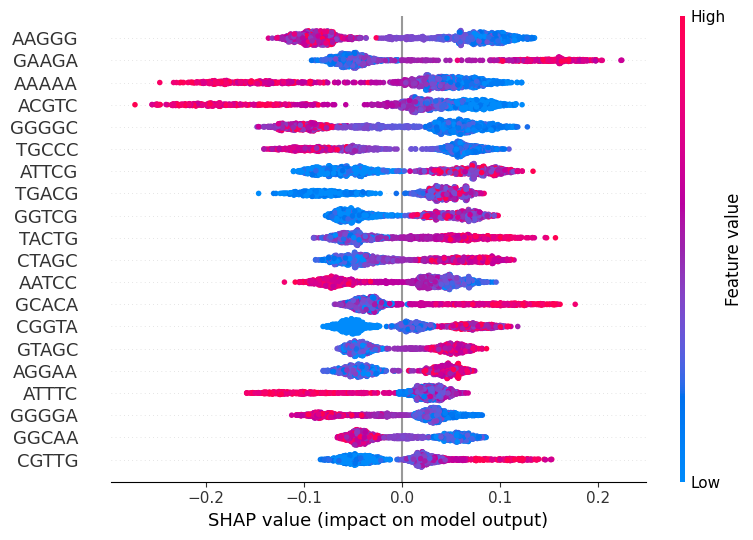

In [38]:
shap.summary_plot(CN_shap_values[1], CP_NU_X_train, plot_size=0.2)

In [39]:
shap_df = pd.DataFrame(CN_shap_values[0], columns=CP_NU_X_train.columns)


In [40]:
CN_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [41]:
CN_shap_FI.head(100)

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,AAAAA,0.137114
1,ACGTC,0.133840
2,CACTC,0.096349
3,ATTTC,0.095071
4,TGAAT,0.090397
...,...,...
95,GTAGT,0.021795
96,TCCCA,0.021664
97,ACGAA,0.021540
98,CCTGC,0.021427


In [42]:
# shap.summary_plot(CN_shap_values[0], CP_NU_X_train, show=False, max_display=30, plot_size=0.2)

In [43]:
#Classifier results with CN_feature_importance

In [44]:
# Show only feature importances above threshold

CN_SHAP_thres_chosen = CN_shap_FI[CN_shap_FI['Importances'] > 0]
CN_shap_num_chosen = len(CN_SHAP_thres_chosen)

print(CN_SHAP_thres_chosen)

print("\nAmount of features with importance above 0.015 (selected features):", CN_shap_num_chosen)

    Feature Id  Importances
0        AAAAA     0.137114
1        ACGTC     0.133840
2        CACTC     0.096349
3        ATTTC     0.095071
4        TGAAT     0.090397
..         ...          ...
989      CTACA     0.000167
990      TTAAT     0.000165
991      CCATT     0.000144
992      GCATT     0.000030
993      CACGG     0.000024

[994 rows x 2 columns]

Amount of features with importance above 0.015 (selected features): 994


In [45]:
print("Sum of total feature importances: ", sum(CN_shap_FI.Importances))
print("Sum of feature importances > 0: ", sum(CN_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances > 0:  8.622797498247191


In [46]:
# Select features with importance values above 0.1

CN_shap_selected_feat = CN_shap_FI[:CN_shap_num_chosen]['Feature Id'].tolist()

# print(CN_shap_selected_feat)

['AAAAA', 'ACGTC', 'CACTC', 'ATTTC', 'TGAAT', 'AAGGG', 'GGCAG', 'GGGGC', 'AATAT', 'TGACG', 'TGCCC', 'TCAAT', 'CCTCT', 'AATCC', 'GCAGT', 'GACAG', 'ATTCG', 'GGGGA', 'ACCGA', 'GAAGA', 'GGTCG', 'TTCAA', 'TACTG', 'CGGTA', 'GTACG', 'CATCT', 'ATCAC', 'CGTTG', 'CCCAA', 'AGGAA', 'TAACC', 'CTAGC', 'TTGTC', 'GTAGC', 'GGCAA', 'TCTCC', 'AACCC', 'CAGAC', 'GCTCT', 'GGATC', 'TTGCT', 'CCAAT', 'ATCTC', 'GCACA', 'GACTT', 'CTCGC', 'CGAGT', 'TAAGG', 'GGGAT', 'TTAAA', 'GTTAC', 'AACGA', 'CAGAT', 'GGTAT', 'GGTGA', 'TAGCC', 'GTATG', 'ACACG', 'GACGA', 'TGTAC', 'ATGCC', 'GGGAG', 'CCGGC', 'CTCTA', 'ACGCA', 'TGAAG', 'CAATA', 'GAAGT', 'CTAGT', 'TATAC', 'AAGTT', 'GAGTG', 'CGTCT', 'TGGGG', 'GTTAG', 'CTCAG', 'CGCAT', 'GCCCC', 'CAGTA', 'CCCCA', 'AGCCC', 'AGAGT', 'CTGTA', 'GATGC', 'TGAAC', 'CAATT', 'GATAG', 'TAGGG', 'TGTTG', 'CCTCC', 'ACCCT', 'AGCAG', 'CGAAA', 'CCCTC', 'TTCCC', 'GTAGT', 'TCCCA', 'ACGAA', 'CCTGC', 'AGGGG', 'CTGGG', 'TGCTC', 'CAAGT', 'AGTTG', 'TAGAC', 'CTATG', 'GAGCT', 'GTAGA', 'CTTAC', 'GAATG', 'GTTCT', 

In [47]:
CP_NU_X_train.shape

(1464, 1024)

In [48]:
# See original training set

CP_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835


In [49]:
#Create training set with selected features 

CN_X_train_shap_selected = CP_NU_X_train[CN_shap_selected_feat]
CN_X_train_shap_selected.head()

,AAAAA,ACGTC,CACTC,ATTTC,TGAAT,AAGGG,GGCAG,GGGGC,AATAT,TGACG,...,TGGCG,GAAGG,TACGC,ATGAG,TGGCA,CTACA,TTAAT,CCATT,GCATT,CACGG
0,0.003643,0.000317,0.001267,0.002376,0.001109,0.001267,0.000792,0.000475,0.002059,0.000158,...,0.000475,0.001584,0.000158,0.001109,0.000792,0.000475,0.001109,0.000950,0.001109,0.000475
1,0.002914,0.000000,0.000291,0.000000,0.001166,0.001748,0.002914,0.004371,0.000291,0.000000,...,0.000291,0.002040,0.000291,0.000583,0.001166,0.001166,0.000291,0.002040,0.000583,0.000583
2,0.002291,0.000000,0.000000,0.001375,0.000917,0.002750,0.003208,0.003208,0.000917,0.000000,...,0.001375,0.001833,0.000000,0.000458,0.002291,0.000000,0.002291,0.001833,0.000000,0.002750
3,0.000000,0.000000,0.001484,0.000495,0.000000,0.003464,0.003464,0.005938,0.000000,0.000495,...,0.002969,0.002969,0.000000,0.001979,0.001979,0.000495,0.000000,0.000495,0.000000,0.000000
4,0.013061,0.000207,0.000829,0.001348,0.002591,0.001037,0.001348,0.000207,0.001866,0.000415,...,0.000207,0.001037,0.000415,0.001037,0.000622,0.001659,0.001451,0.001037,0.001451,0.000104


In [50]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CN_X_train_shap_selected.columns) == CN_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [51]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CN_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", CP_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1464, 994)
Shape of y_train (number of labels): (1464,)


In [52]:
# Create pool object for selected feature data
print("Original number of features:", len(CN_feature_names), "\n Number of selected features:", len(CN_shap_selected_feat))

CN_shap_selected_train_pool = Pool(CN_X_train_shap_selected, CP_NU_y_train, feature_names=CN_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 994


In [53]:
#Create new model for data with selected features
CN_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CN_FIFS_shap_model.fit(CN_shap_selected_train_pool)

Learning rate set to 0.08068
0:	learn: 0.6776480	total: 147ms	remaining: 2m 26s
1:	learn: 0.6656461	total: 261ms	remaining: 2m 10s
2:	learn: 0.6538041	total: 371ms	remaining: 2m 3s
3:	learn: 0.6430705	total: 481ms	remaining: 1m 59s
4:	learn: 0.6316559	total: 598ms	remaining: 1m 58s
5:	learn: 0.6190787	total: 720ms	remaining: 1m 59s
6:	learn: 0.6106979	total: 834ms	remaining: 1m 58s
7:	learn: 0.6016945	total: 953ms	remaining: 1m 58s
8:	learn: 0.5932477	total: 1.07s	remaining: 1m 57s
9:	learn: 0.5839626	total: 1.18s	remaining: 1m 57s
10:	learn: 0.5732463	total: 1.3s	remaining: 1m 57s
11:	learn: 0.5648931	total: 1.42s	remaining: 1m 56s
12:	learn: 0.5567270	total: 1.53s	remaining: 1m 56s
13:	learn: 0.5505743	total: 1.66s	remaining: 1m 56s
14:	learn: 0.5434188	total: 1.78s	remaining: 1m 56s
15:	learn: 0.5348921	total: 1.89s	remaining: 1m 56s
16:	learn: 0.5286133	total: 2.01s	remaining: 1m 56s
17:	learn: 0.5227501	total: 2.13s	remaining: 1m 56s
18:	learn: 0.5171750	total: 2.24s	remaining: 1m

In [54]:
#Check parameters used in this model fit

CN_FIFS_shap_params = CN_FIFS_shap_model.get_all_params()
print("Basic model parameters:", CN_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.0806799978017807, 

In [55]:
#Prediction using X_test only for selected features data
CN_FIFS_shap_y_pred = CN_FIFS_shap_model.predict(CP_NU_X_test)

#Predication probability for selected features data

CN_FIFS_shap_y_prob = CN_FIFS_shap_model.predict_proba(CP_NU_X_test)

In [56]:
# Calculate F1 score and get classification report

print("Model 5: Feature selection (SHAP) w/ threshold > 0 - Cytoplasm & nucleus")

print("Number of chosen features:", len(CN_shap_selected_feat), "\n")

CN_FIFS_shap_cr = classification_report(CP_NU_y_test, CN_FIFS_shap_y_pred, digits=4)
print(CN_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(CP_NU_y_test, CN_FIFS_shap_y_pred))

CN_FIFS_shap_f1 = f1_score(CP_NU_y_test, CN_FIFS_shap_y_pred, average='macro')
print(f"F1 Score: {CN_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(CP_NU_y_test, CN_FIFS_shap_y_prob))

Model 5: Feature selection (SHAP) w/ threshold > 0 - Cytoplasm & nucleus
Number of chosen features: 994 

              precision    recall  f1-score   support

           0     0.6022    0.7864    0.6821       206
           3     0.5464    0.3312    0.4125       160

    accuracy                         0.5874       366
   macro avg     0.5743    0.5588    0.5473       366
weighted avg     0.5778    0.5874    0.5642       366

Accuracy score:  0.587431693989071
F1 Score: 0.5472783125127996


In [57]:
# Confusion matrix for selected data

print("real values shape:", CP_NU_y_test.shape)
print("prediction shape:", CN_FIFS_shap_y_pred.shape)

CN_FIFS_shap_y_pred_fl = CN_FIFS_shap_y_pred
print("flattened prediction values shape:", CN_FIFS_shap_y_pred_fl.ravel().shape, "\n")

CN_FIFS_shap_cMatrix = confusion_matrix(CP_NU_y_test, CN_FIFS_shap_y_pred_fl)
print(CN_FIFS_shap_cMatrix)

real values shape: (366,)
prediction shape: (366, 1)
flattened prediction values shape: (366,) 

[[162  44]
 [107  53]]


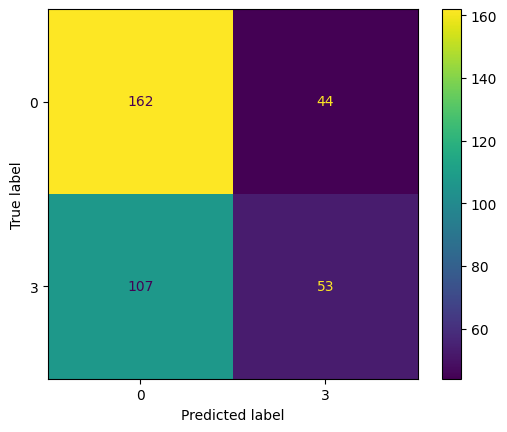

In [58]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CN_FIFS_shap_cMatrix, display_labels=CN_FIFS_shap_model.classes_)
disp.plot()
plt.show()

*********
BELOW CODE NOT NECESSARY

In [61]:
#Classifier results with newtry_feature_importance

In [ ]:
#Try####

vals= np.abs(CN_shap_values).mean(0)

newtry_feature_importance = pd.DataFrame(list(zip(CP_NU_X_train.columns, sum(vals))), columns=['col_name','feature_importanCN_vals'])
newtry_feature_importance.sort_values(by=['feature_importanCN_vals'], ascending=False,inplace=True)
newtry_feature_importance

,col_name,feature_importanCN_vals
42,AAGGG,119.195244
520,GAAGA,108.751967
0,AAAAA,106.269651
109,ACGTC,103.249626
681,GGGGC,100.562149
...,...,...
998,TTGCG,0.000000
372,CCTCA,0.000000
94,ACCTG,0.000000
436,CGTCA,0.000000


In [ ]:
newtry_feature_importance.head(10)

,col_name,feature_importanCN_vals
42,AAGGG,119.195244
520,GAAGA,108.751967
0,AAAAA,106.269651
109,ACGTC,103.249626
681,GGGGC,100.562149
917,TGCCC,98.292031
246,ATTCG,98.079661
902,TGACG,83.611785
694,GGTCG,78.122728
798,TACTG,77.797110


In [62]:
newtry_feature_importance.head(500)

,col_name,feature_importanCN_vals
42,AAGGG,119.195244
520,GAAGA,108.751967
0,AAAAA,106.269651
109,ACGTC,103.249626
681,GGGGC,100.562149
...,...,...
1000,TTGGA,5.869724
913,TGCAC,5.849353
10,AAAGG,5.845330
768,TAAAA,5.803851


In [63]:
# Show only feature importances above 0.1

CN_newSHAP_thres_chosen = newtry_feature_importance[:300]
CN_newshap_num_chosen = len(CN_newSHAP_thres_chosen)

print(CN_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CN_newshap_num_chosen)

     col_name  feature_importanCN_vals
42      AAGGG               119.195244
520     GAAGA               108.751967
0       AAAAA               106.269651
109     ACGTC               103.249626
681     GGGGC               100.562149
...       ...                      ...
1022    TTTTG                 9.563471
842     TCAGG                 9.551405
1015    TTTCT                 9.512146
152     AGCGA                 9.497435
878     TCGTG                 9.492443

[300 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 300


In [64]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importanCN_vals))
print("Sum of feature importances >=0.1: ", sum(CN_newSHAP_thres_chosen.feature_importanCN_vals))

Sum of total feature importances:  10816.48690022639
Sum of feature importances >=0.1:  7720.346266415885


In [65]:
# Select features with importance values above 0.1

CN_newshap_selected_feat = newtry_feature_importance[:CN_newshap_num_chosen]['col_name'].tolist()

print(CN_newshap_selected_feat)

['AAGGG', 'GAAGA', 'AAAAA', 'ACGTC', 'GGGGC', 'TGCCC', 'ATTCG', 'TGACG', 'GGTCG', 'TACTG', 'CTAGC', 'AATCC', 'GCACA', 'CGGTA', 'GTAGC', 'AGGAA', 'ATTTC', 'GGGGA', 'GGCAA', 'CGTTG', 'GGTGA', 'TGAAT', 'CATCT', 'CCTCT', 'AATAT', 'GTACG', 'GCAGT', 'CAGAT', 'CAGAC', 'AACGA', 'GACGA', 'CACTC', 'ACGCA', 'TCAAT', 'ATCAC', 'CCCAA', 'TTGTC', 'GAAGT', 'ACCGA', 'GTTAC', 'TCTCC', 'TGAAG', 'CCGGC', 'GCCCC', 'GTTAG', 'CTCAG', 'TTGCT', 'TGAAC', 'CCCCA', 'CTCTA', 'CTGTA', 'TCGTA', 'GCTCT', 'GTATG', 'TTCAA', 'CTAGT', 'ATGCC', 'CTCGC', 'CGAGT', 'ATCTC', 'TAAGG', 'CCAAT', 'GGGAT', 'TGTAC', 'AGTTG', 'GTTTG', 'TAGCC', 'GACAG', 'CCTCC', 'GGATC', 'AGAGT', 'CGCAT', 'GGGAG', 'AACCC', 'TAGAC', 'TGGGG', 'GTTCT', 'GGCGA', 'GATAG', 'GACTT', 'GGCAG', 'TCCCA', 'AGCAG', 'TGGCT', 'CAAGT', 'AAGTT', 'ACACG', 'CGACA', 'AGAAG', 'TAGGG', 'TAACC', 'CTTGT', 'GATGC', 'CTGGG', 'TCGGT', 'CCCCG', 'TTCCC', 'ACGAA', 'ATGCG', 'AAGGA', 'CTTAC', 'TGCTC', 'CCTGC', 'CTATG', 'CAGTA', 'GAGTG', 'GTCTG', 'CGTCT', 'CTAAG', 'TTCGA', 'GGTAT', 

In [66]:
CP_NU_X_train.shape

(1464, 1024)

In [67]:
# See original training set

CP_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835


In [68]:
#Create training set with selected features 

CN_X_train_newshap_selected = CP_NU_X_train[CN_newshap_selected_feat]
CN_X_train_newshap_selected.head()

,AAGGG,GAAGA,AAAAA,ACGTC,GGGGC,TGCCC,ATTCG,TGACG,GGTCG,TACTG,...,CAAAA,CAACT,GTCGT,CCTCG,AGCTA,TTTTG,TCAGG,TTTCT,AGCGA,TCGTG
0,0.001267,0.001584,0.003643,0.000317,0.000475,0.001267,0.000158,0.000158,0.000158,0.000317,...,0.001267,0.000950,0.000317,0.000475,0.000792,0.003168,0.000634,0.002693,0.000317,0.000634
1,0.001748,0.002040,0.002914,0.000000,0.004371,0.003497,0.000291,0.000000,0.000291,0.000583,...,0.000583,0.000874,0.000874,0.001166,0.000874,0.000583,0.000874,0.000291,0.000583,0.000583
2,0.002750,0.002291,0.002291,0.000000,0.003208,0.004125,0.000458,0.000000,0.000000,0.000458,...,0.000458,0.000000,0.000000,0.001833,0.000917,0.000458,0.000458,0.001375,0.000458,0.000458
3,0.003464,0.000000,0.000000,0.000000,0.005938,0.002969,0.000000,0.000495,0.000990,0.000990,...,0.000990,0.000990,0.000000,0.000000,0.000990,0.000000,0.000495,0.000495,0.000000,0.000000
4,0.001037,0.002281,0.013061,0.000207,0.000207,0.000726,0.000207,0.000415,0.000104,0.000311,...,0.002591,0.001037,0.000000,0.000104,0.001244,0.002488,0.001244,0.001762,0.000000,0.000311


In [69]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CN_X_train_newshap_selected.columns) == CN_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [70]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CN_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", CP_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1464, 300)
Shape of y_train (number of labels): (1464,)


In [71]:
# Create pool object for selected feature data
print("Original number of features:", len(CN_feature_names), "\n Number of selected features:", len(CN_newshap_selected_feat))

CN_newshap_selected_train_pool = Pool(CN_X_train_newshap_selected, CP_NU_y_train, feature_names=CN_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 300


In [72]:
#Create new model for data with selected features
CN_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CN_FIFS_newshap_model.fit(CN_newshap_selected_train_pool)

Learning rate set to 0.08068
0:	learn: 0.6780700	total: 49.9ms	remaining: 49.9s
1:	learn: 0.6628409	total: 91.5ms	remaining: 45.7s
2:	learn: 0.6500334	total: 128ms	remaining: 42.5s
3:	learn: 0.6382407	total: 167ms	remaining: 41.5s
4:	learn: 0.6251351	total: 207ms	remaining: 41.2s
5:	learn: 0.6170847	total: 247ms	remaining: 41s
6:	learn: 0.6081973	total: 287ms	remaining: 40.7s
7:	learn: 0.5987954	total: 323ms	remaining: 40s
8:	learn: 0.5886451	total: 360ms	remaining: 39.6s
9:	learn: 0.5802156	total: 394ms	remaining: 39s
10:	learn: 0.5708340	total: 431ms	remaining: 38.8s
11:	learn: 0.5621615	total: 469ms	remaining: 38.6s
12:	learn: 0.5554424	total: 505ms	remaining: 38.3s
13:	learn: 0.5478992	total: 542ms	remaining: 38.1s
14:	learn: 0.5396446	total: 580ms	remaining: 38.1s
15:	learn: 0.5319683	total: 615ms	remaining: 37.8s
16:	learn: 0.5249003	total: 650ms	remaining: 37.6s
17:	learn: 0.5186915	total: 686ms	remaining: 37.4s
18:	learn: 0.5123881	total: 723ms	remaining: 37.3s
19:	learn: 0.505

In [73]:
#Check parameters used in this model fit

CN_FIFS_newshap_params = CN_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", CN_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.0806799978017807, 

In [74]:
#Prediction using X_test only for selected features data
CN_FIFS_newshap_y_pred = CN_FIFS_newshap_model.predict(CP_NU_X_test)

#Predication probability for selected features data

CN_FIFS_newshap_y_prob = CN_FIFS_newshap_model.predict_proba(CP_NU_X_test)

In [75]:
# Calculate F1 score and get classification report

CN_FIFS_newshap_f1 = f1_score(CP_NU_y_test, CN_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {CN_FIFS_newshap_f1}")

CN_FIFS_newshap_cr = classification_report(CP_NU_y_test, CN_FIFS_newshap_y_pred, digits=4)
print(CN_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(CP_NU_y_test, CN_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_NU_y_test, CN_FIFS_newshap_y_prob))

F1 Score: 0.6195818621811402
              precision    recall  f1-score   support

           0     0.6506    0.7864    0.7121       206
           3     0.6239    0.4562    0.5271       160

    accuracy                         0.6421       366
   macro avg     0.6373    0.6213    0.6196       366
weighted avg     0.6389    0.6421    0.6312       366

Accuracy score:  0.6420765027322405


In [76]:
# Confusion matrix for selected data

print("real values shape:", CP_NU_y_test.shape)
print("prediction shape:", CN_FIFS_newshap_y_pred.shape)

CN_FIFS_newshap_y_pred_fl = CN_FIFS_newshap_y_pred
print("flattened prediction values shape:", CN_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

CN_FIFS_newshap_cMatrix = confusion_matrix(CP_NU_y_test, CN_FIFS_newshap_y_pred_fl)
print(CN_FIFS_newshap_cMatrix)

real values shape: (366,)
prediction shape: (366, 1)
flattened prediction values shape: (366,) 

[[162  44]
 [ 87  73]]


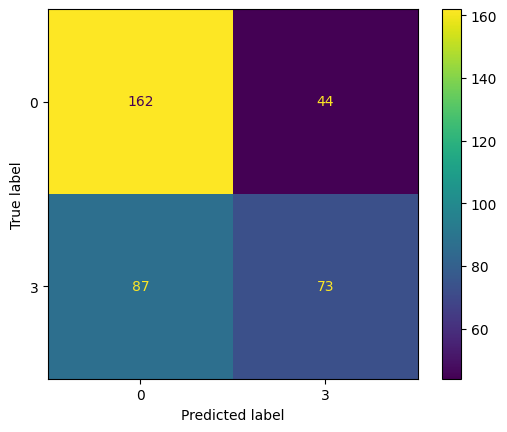

In [77]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CN_FIFS_newshap_cMatrix, display_labels=CN_FIFS_newshap_model.classes_)
disp.plot()
plt.show()